In [1]:
from skimage.segmentation import slic, felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import argparse
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches
import glob
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(-0.5, 1030.5, 1030.5, -0.5)

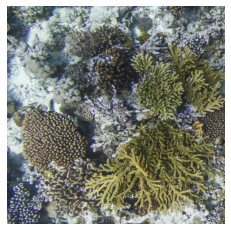

In [2]:
from google.colab import drive
drive.mount('/content/drive')
image_file_and_path = 'drive/MyDrive/reef support/test3.jpg'
image = img_as_float(io.imread(image_file_and_path))
plt.imshow(image)
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


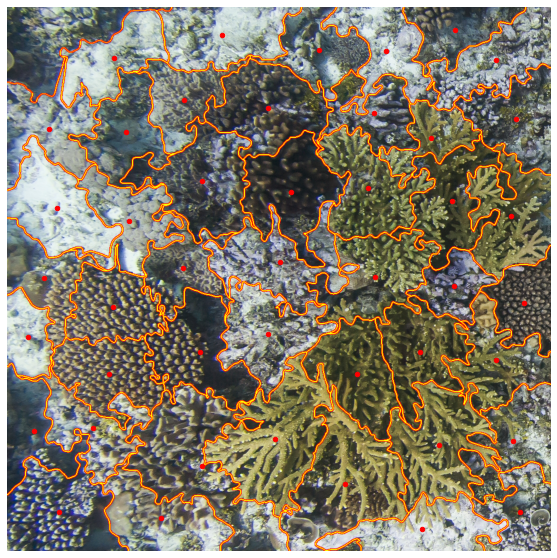

In [3]:
# apply SLIC and extract (approximately) the supplied number
# of segments
n = 50
segments = slic(image, n_segments = n, sigma = 5, compactness=20)
regions = regionprops(segments)

centroids = []
for i, region in enumerate(regions):
    y, x = region.centroid
    c = {}
    c['index'] = i
    c['x'] = x
    c['y'] = y
    centroids.append(c)

# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (n), figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments, outline_color=(255,0,0)))
ax.scatter(x=[c['x'] for c in centroids], y=[c['y'] for c in centroids], c='r', s=20)
plt.axis("off")
plt.show()

In [4]:
model_weights_path = 'drive/MyDrive/reef support/googlenet_state_dict_3.pth'

#download GoogLeNet model architecture
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.fc =  nn.Linear(1024, 6)
optimizer = optim.Adam(model.parameters(), lr=1)

#load the trained weights
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model = model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
def get_coverage(image, model, device, encoding, n_segments=50):
  
  #apply slic segmentation on the image
  segments = slic(image, n_segments = n_segments, sigma = 5, compactness=20)
  regions = regionprops(segments)

  #gather data about cluster centroids
  centroids = []
  for i, region in enumerate(regions):
      y, x = region.centroid
      c = {}
      c['index'] = i
      c['x'] = x
      c['y'] = y
      centroids.append(c)

  #add mirror padding to enable classification of points on the border
  clf_window = 224
  pad_image = np.pad(image, clf_window//2, 'symmetric', reflect_type='even')
  pad_image = pad_image[:,:,clf_window//2:clf_window//2+3]

  #for each centroid, cut a window around it and apply classification on the window
  #save labels associated with each centroid
  for c in centroids:
    square = pad_image[int(c['x']) : int(c['x'])+clf_window, int(c['y']) : int(c['y'])+clf_window]
    square = np.moveaxis(square, -1, 0)
    square = np.expand_dims(square, axis=0)
    input = torch.tensor(square).float()
    
    #the model expects the input tensors to be normalized this way:
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    input = normalize(input)

    input = input.to(device)
    output = model(input)
    pred = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    c['label'] = pred

  #apply centroid labels to the corresponding clusters
  new_segments = np.zeros(segments.shape)
  for c in centroids:  
    new_segments = np.where(segments == c['index'], c['label'][0], new_segments)
  
  unique, counts = np.unique(new_segments, return_counts=True)
  unique = [encoding[x] for x in unique]
  coverage = dict(zip(unique, counts))

  #calculate the coverage percentage of each class
  s = sum(coverage.values())
  coverage.update((k,coverage[k]/s) for k in coverage.keys())

  return new_segments, coverage

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.


{'Algae': 0.4787645078229587, 'Hard Coral': 0.5212354921770413}


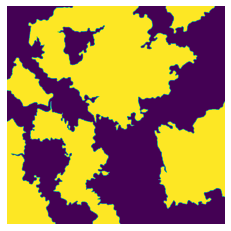

In [6]:
#mapping between classifier output and class names
encoding = {0:'Algae',1:'Hard Coral',2:'Other',3:'Soft Coral',4:'Other Invertebrates',5:'Sponge'}

image_file_and_path = 'drive/MyDrive/reef support/test3.jpg'
image = img_as_float(io.imread(image_file_and_path))

segments, coverage = get_coverage(image, model, device, encoding, 50)
im = plt.imshow(segments)
plt.axis("off")

print(coverage)

In [7]:
#calculate the coverage of all images in a folder, return the average
def coverage_of_folder(path, model, device, n_segments, encoding, max_files=50):

  coverages = []
  avg_coverage = {}
  for i, filename in enumerate(glob.iglob(path + '**/*.jpg', recursive=False)):
    image = img_as_float(io.imread(filename))
    _, coverage = get_coverage(image, model, device, encoding, n_segments)
    coverages.append(coverage)
    
    #it runs out of memory with too many files so we set a limit here
    if i> max_files:
      break
  
  for val in encoding.values():
    avg = sum(item.get(val,0) for item in coverages) / len(coverages)
    avg_coverage[val] = avg
  return avg_coverage


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.


{'Algae': 0.7841584357087839, 'Hard Coral': 0.02300012900625474, 'Other': 0.05313848308469331, 'Soft Coral': 0.0016081662890744055, 'Other Invertebrates': 0.11810485834261433, 'Sponge': 0.019989927568579282}


<BarContainer object of 6 artists>

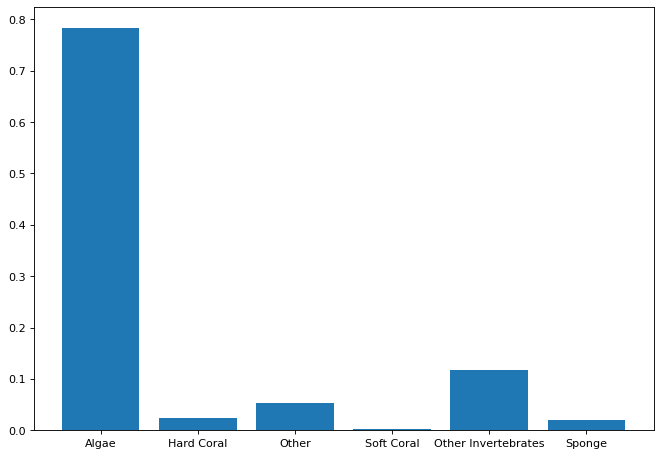

In [8]:
path = '/content/drive/MyDrive/reef support/SEAVIEW/ATL'

#path = 'drive/MyDrive/Reef Support Benthic Data/SEAVIEW/IND_CHA'

coverage = coverage_of_folder(path, model, device, 50, encoding)
print(coverage)
names = list(coverage.keys())
values = list(coverage.values())
plt.figure(figsize=(10, 7), dpi=80)
plt.bar(range(len(coverage)), values, tick_label=names)